In [13]:
import numpy as np
import matplotlib.pyplot as plt
import alc

In [2]:
X_train, Y_train, X_val, Y_val = alc.cargarDataset("cats_and_dogs/")

print(X_train.shape, Y_train.shape)  # (1536, 3000) (2, 3000)
print(X_val.shape, Y_val.shape)      # (1536, 2000) (2, 2000)

(1536, 2000) (2, 2000)
(1536, 1000) (2, 1000)


In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

if N == M:
    pXchols = alc.inversa(Xc)
    Wchols = alc.prodMat(Yc, pXchols)
else:
    if N > M:
        # print("Caso (a) N > M")
        Xh = alc.prodMat(Xc.T, Xc) 
    else:
        # print("Caso (b) N < M")
        Xh = alc.prodMat(Xc, Xc.T)
    # print("Calculo de Cholesky")
    L = alc.calculaCholesky(Xh)

    Wchols = alc.pinvEcuacionesNormales(X_train,L,Y_train)

In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

# Hace con @ para poder evaluar, en el modulo esta la version sin @
Q, R = alc.QR_con_HH_NP(Xc.T)

Whh = alc.pinvHouseHolder(Q, R, Yc)

In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

Q, R = alc.QR_con_GS(Xc.T)

Wgm = alc.pinvGramSchmidt(Q, R, Yc)

In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

U, S, V = alc.svd_reducida_np(Xc)

Wsvd = alc.pinvSVD(U, S, V, Yc)

In [ ]:
# Generar predicciones de cada uno
Y_pred_svd = alc.prodMat(Wsvd, X_val)
Y_pred_chols = alc.prodMat(Wchols, X_val)
Y_pred_gm = alc.prodMat(Wgm, X_val)
Y_pred_hh = alc.prodMat(Whh, X_val)

In [ ]:
M_chols, acc_chols = alc.matriz_confusion(Y_pred_chols, Y_val)
print("Matriz de confusión:\n", M_chols)
print("Accuracy Cholesky:", acc_chols)

In [ ]:
M_gm, acc_gm = alc.matriz_confusion(Y_pred_gm, Y_val)
print("Matriz de confusión:\n", M_gm)
print("Accuracy QR (Gram-Schmidt):", acc_gm)

In [ ]:
M_hh, acc_hh = alc.matriz_confusion(Y_pred_hh, Y_val)
print("Matriz de confusión:\n", M_hh)
print("Accuracy QR (Householder):", acc_hh)

In [ ]:
# Predicciones del algoritmo con SVD
M_svd, acc_svd = alc.matriz_confusion(Y_pred_svd, Y_val)
print("Matriz de confusión:\n", M_svd)
print("Accuracy SVD:", acc_svd)

In [14]:
acc_gm = 0.25
acc_hh = 0.30
acc_chols = 0.20
acc_svd = 0.35

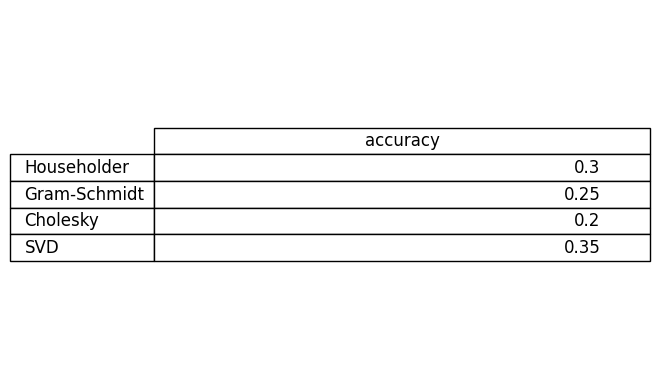

In [ ]:
# Data
rows = ["Householder", "Gram-Schmidt", "Cholesky", "SVD"]
values = [acc_hh, acc_gm, acc_chols, acc_svd]

fig, ax = plt.subplots()
ax.axis('off')  # hide plot box

table = ax.table(
    cellText=[[v] for v in values],   # each row contains one column
    rowLabels=rows,
    colLabels=["Accuracy"],
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.6)

plt.show()